In [1]:
import pandas as pd
pd.options.display.max_columns =200
import numpy as np
from datetime import datetime, timedelta

import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import mapclassify
import seaborn as sns


## I. Correlating COVID case statistics with Census Demographic Social Vulnerability
This notebook tests a number of different approaches to correlating COVID statistics with Social Vulnerability (as defined by the CDC Social Vulnerability Index). 

COVID data used was collected by the [New York Times](https://github.com/nytimes/covid-19-data) for cumulative cases by county in the U.S. which is updated daily. 


In [2]:
## data imports
svi = pd.read_csv("data/svi/svi_2018_counties_state_ranked.csv")
covid = pd.read_csv("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv")
# counties = gpd.read_file('./data_processing/tl_2019_us_county/tl_2019_us_county.shp')

In [4]:
# convert date to datetime format
covid['dt'] = pd.to_datetime(covid['date'], infer_datetime_format=True)

# create totals for cases and deaths
# total_covid = covid.groupby('fips')['cases','deaths'].sum().reset_index()
# total_covid['fips'] = total_covid['fips'].astype(int)

total_covid = covid[covid['date']=='2020-08-10']
# total_covid['fips'] = total_covid['fips'].astype(int)

In [6]:
total_covid.sort_values(by='fips')

,date,county,state,fips,cases,deaths,dt
418169,2020-08-10,Autauga,Alabama,1001.0,1222,22,2020-08-10
418170,2020-08-10,Baldwin,Alabama,1003.0,3714,28,2020-08-10
418171,2020-08-10,Barbour,Alabama,1005.0,631,5,2020-08-10
418172,2020-08-10,Bibb,Alabama,1007.0,450,5,2020-08-10
418173,2020-08-10,Blount,Alabama,1009.0,947,4,2020-08-10
...,...,...,...,...,...,...,...
420760,2020-08-10,Unknown,Tennessee,NaN,86,0,2020-08-10
421042,2020-08-10,Unknown,Utah,NaN,16,0,2020-08-10
421059,2020-08-10,Unknown,Vermont,NaN,8,0,2020-08-10
421233,2020-08-10,Unknown,Washington,NaN,2,2,2020-08-10


In [9]:
## calculating percent ranking for other forms of SVI
svi['RPL_Theme1States'] = svi.groupby('STATE')['SPL_THEME1'].rank(pct=True)
svi['RPL_Theme2States'] = svi.groupby('STATE')['SPL_THEME2'].rank(pct=True)
svi['RPL_Theme3States'] = svi.groupby('STATE')['SPL_THEME3'].rank(pct=True)
svi['RPL_Theme4States'] = svi.groupby('STATE')['SPL_THEME4'].rank(pct=True)

In [10]:
# merge svi and covid counts
total_covid_svi = total_covid.merge(svi[['FIPS','STATE','COUNTY','E_TOTPOP',
                                         'RPL_ThemesStates',
                                         'RPL_Theme1States',
                                         'RPL_Theme2States',
                                        'RPL_Theme3States',
                                        'RPL_Theme4States','geometry']],left_on='fips',right_on='FIPS')

In [11]:
# calculate population normalized cases and deaths
total_covid_svi['cases_pop'] =total_covid_svi['cases']/total_covid_svi['E_TOTPOP']
total_covid_svi['deaths_pop'] =total_covid_svi['deaths']/total_covid_svi['E_TOTPOP']
# calculate case fatalities
total_covid_svi['case_fatality'] = total_covid_svi['deaths']/total_covid_svi['cases']

## I.a Cases/population  versus SVI composite index

Cases/population calculated for each county plotted against the composite social vulnerability index. 


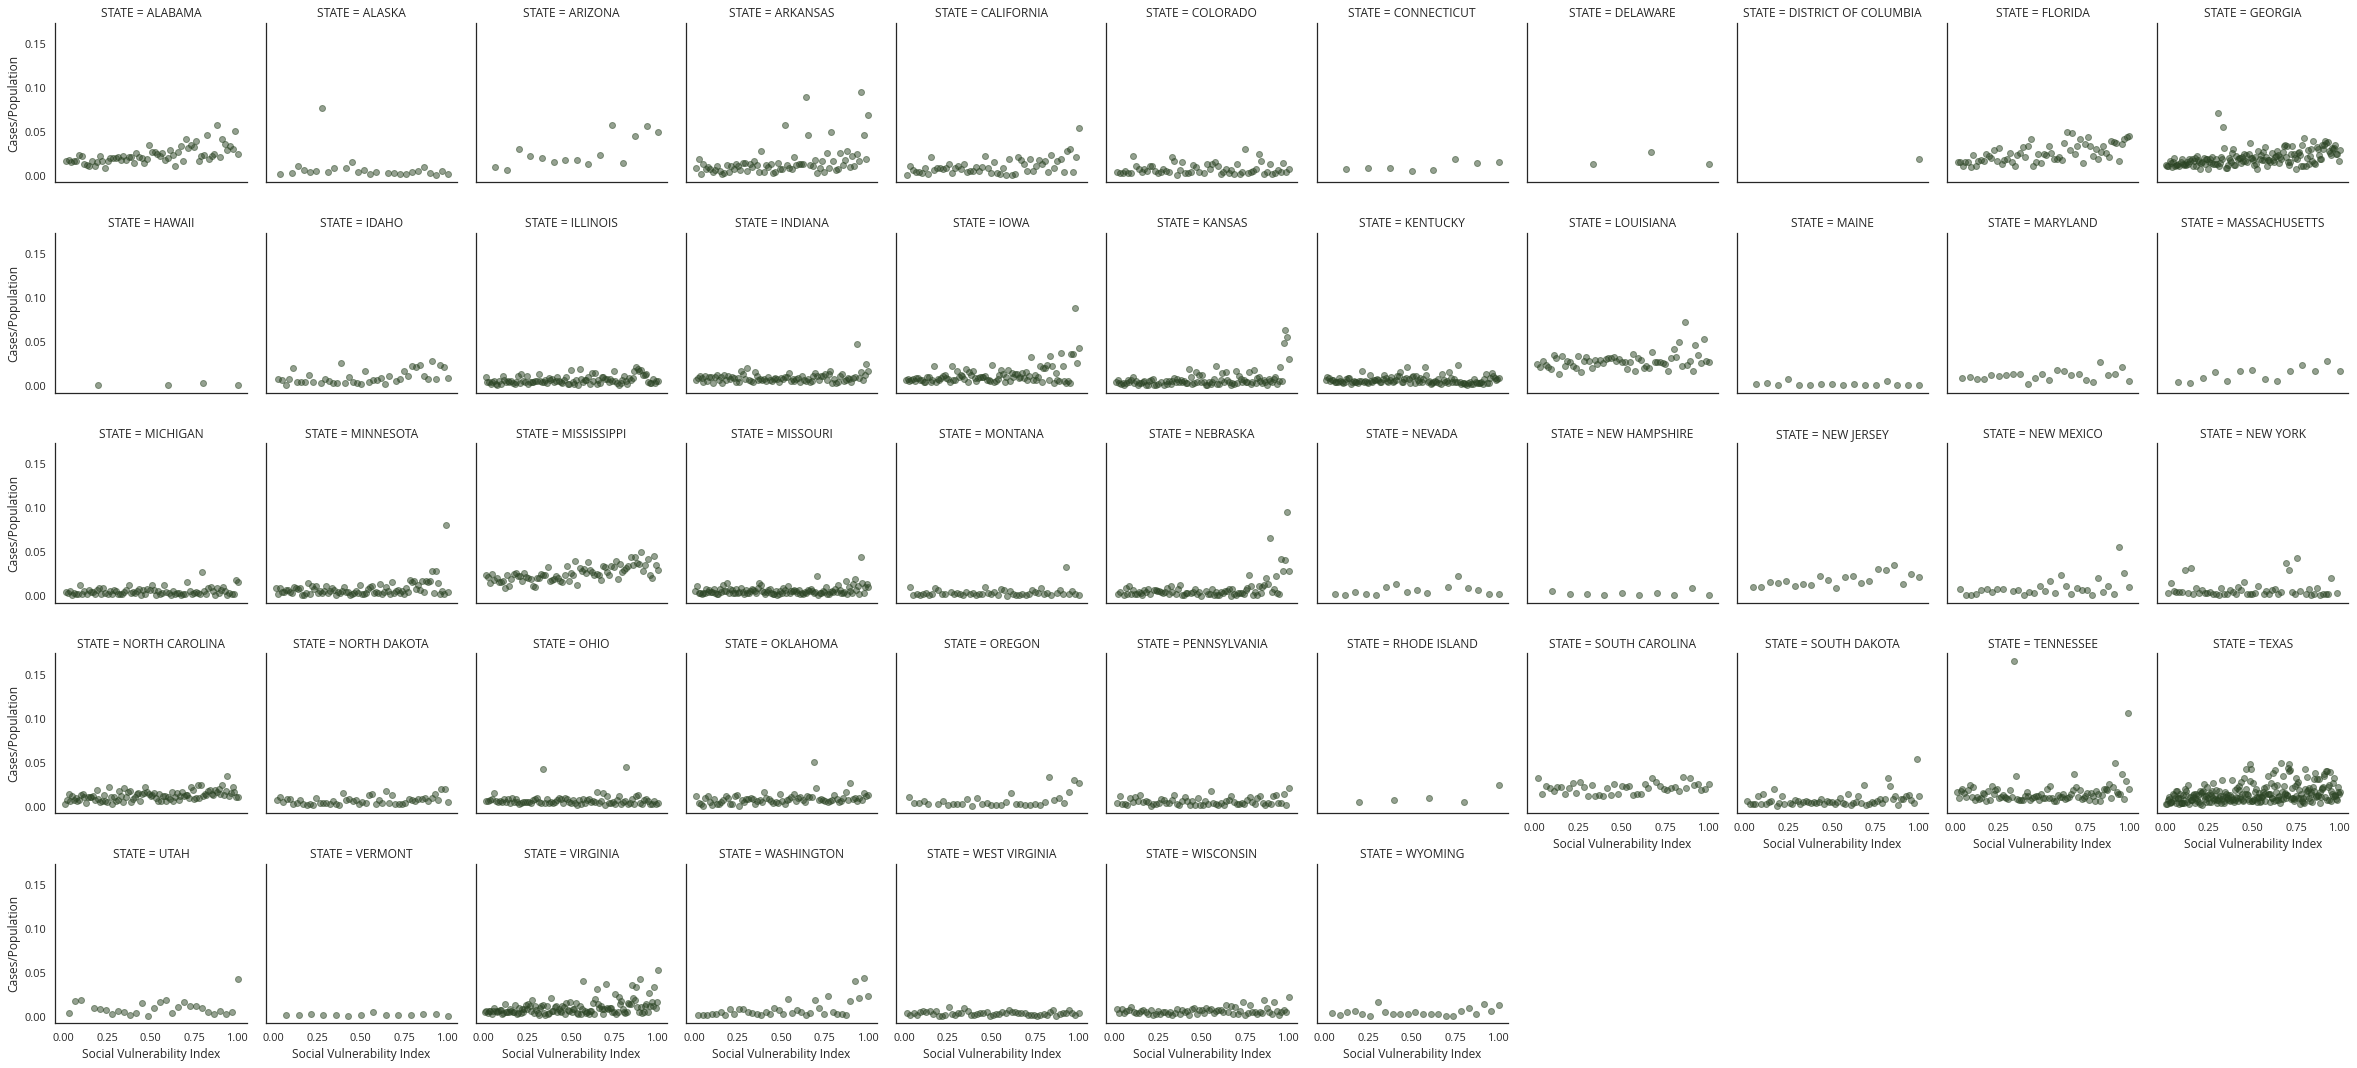

In [12]:
sns.set(font='Open Sans',style="white")
all_counties = sns.FacetGrid(total_covid_svi,col='STATE',col_wrap=11)
all_counties = all_counties.map(plt.scatter, "RPL_ThemesStates", "cases_pop", alpha=0.5,color='#2C4525').set_axis_labels('Social Vulnerability Index','Cases/Population')

## I.b Deaths/population versus SVI composite index

deaths/population calculated for each county plotted against the composite social vulnerability index. 


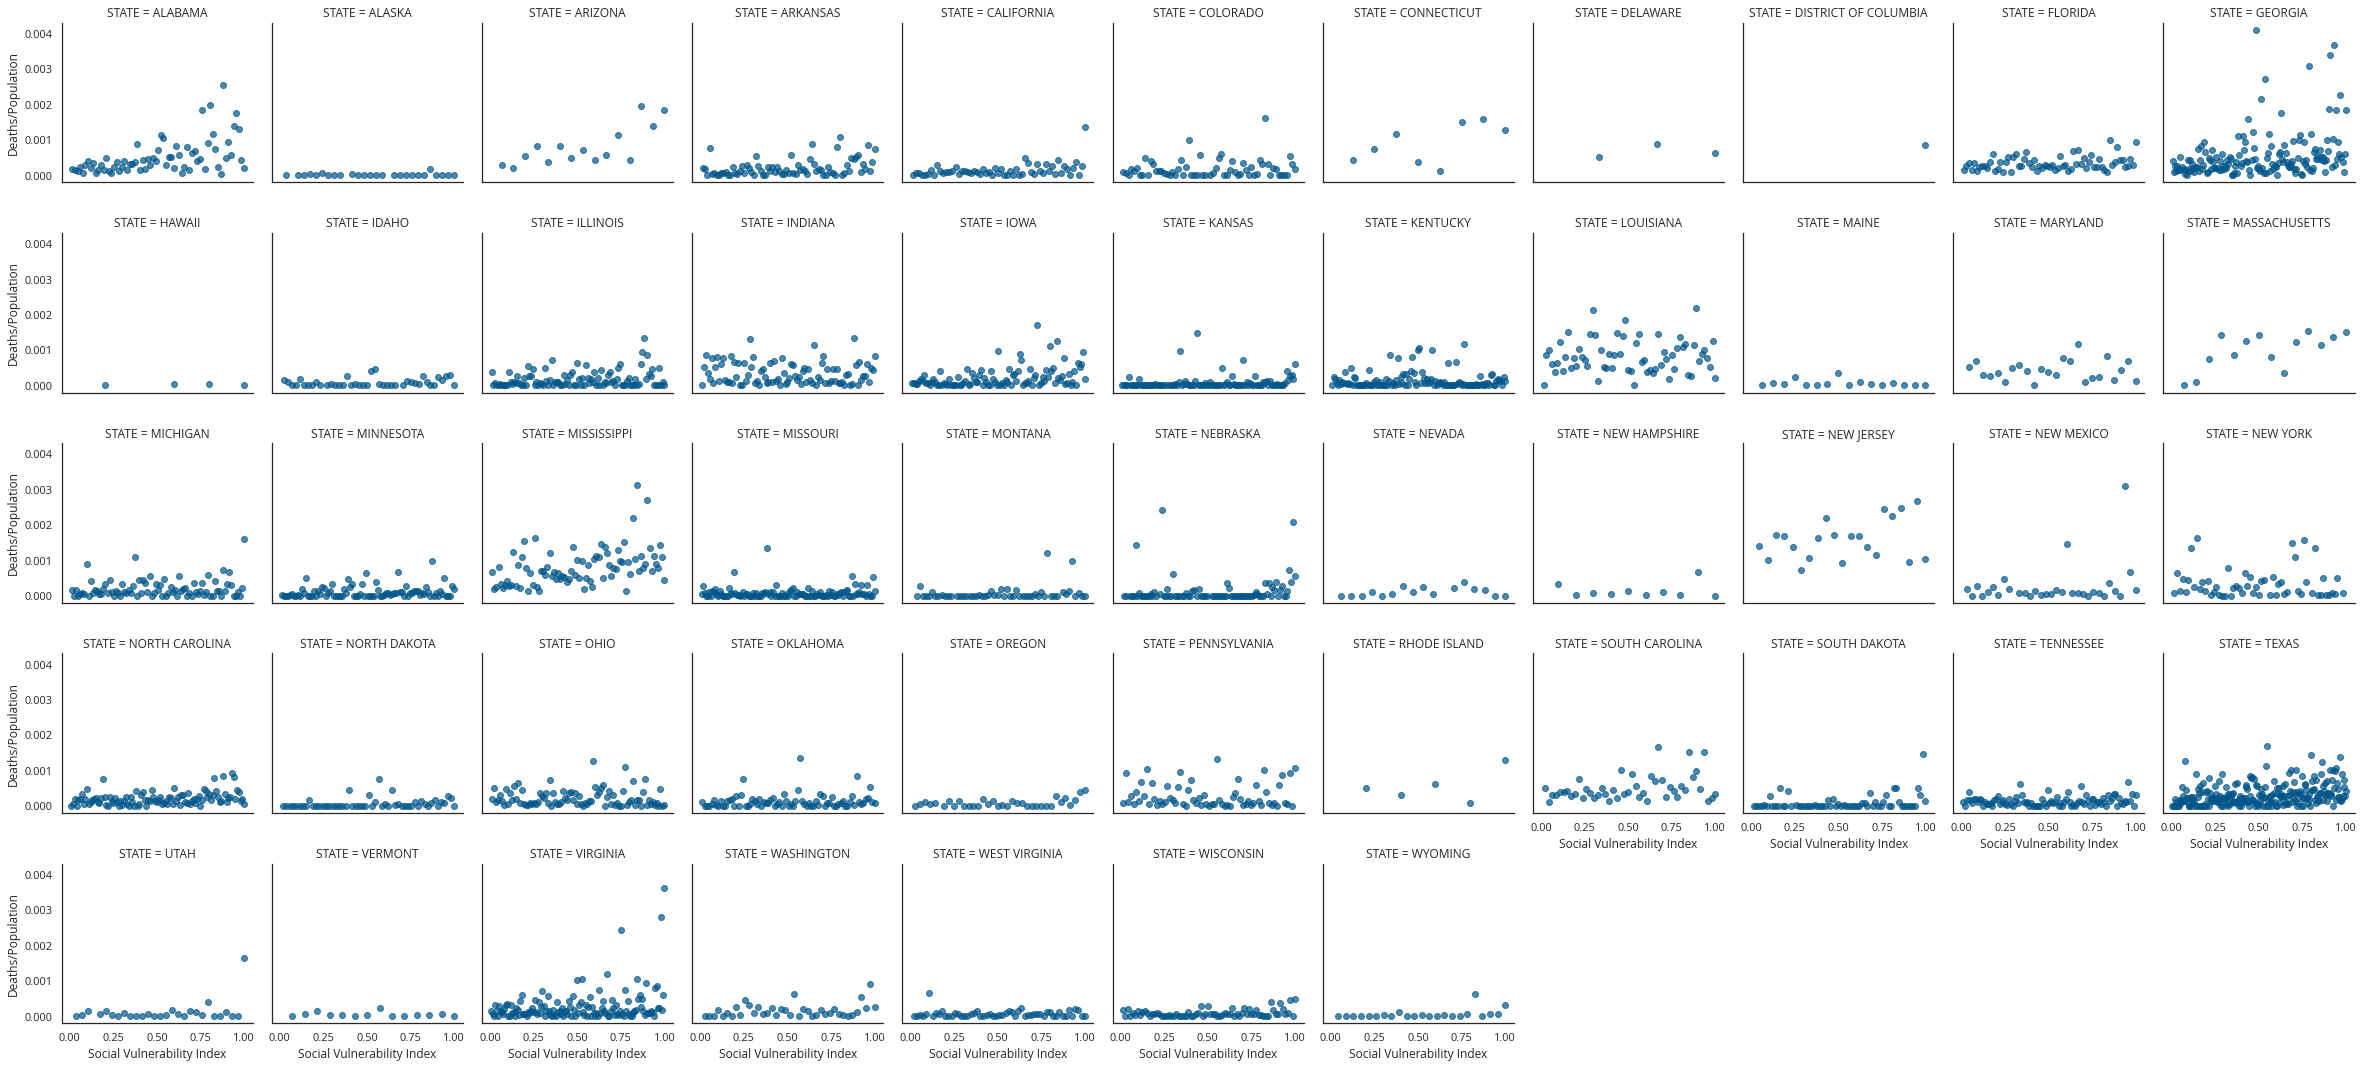

In [13]:
all_counties = sns.FacetGrid(total_covid_svi,col='STATE',col_wrap=11)
all_counties_death = all_counties.map(plt.scatter, "RPL_ThemesStates", "deaths_pop", color='#02568B',alpha=0.7).set_axis_labels('Social Vulnerability Index','Deaths/Population')

## II. Case fatalities versus SVI composite index

Case fatalities (number of deaths / number of cases) calculated for each county plotted against the composite social vulnerability index. 


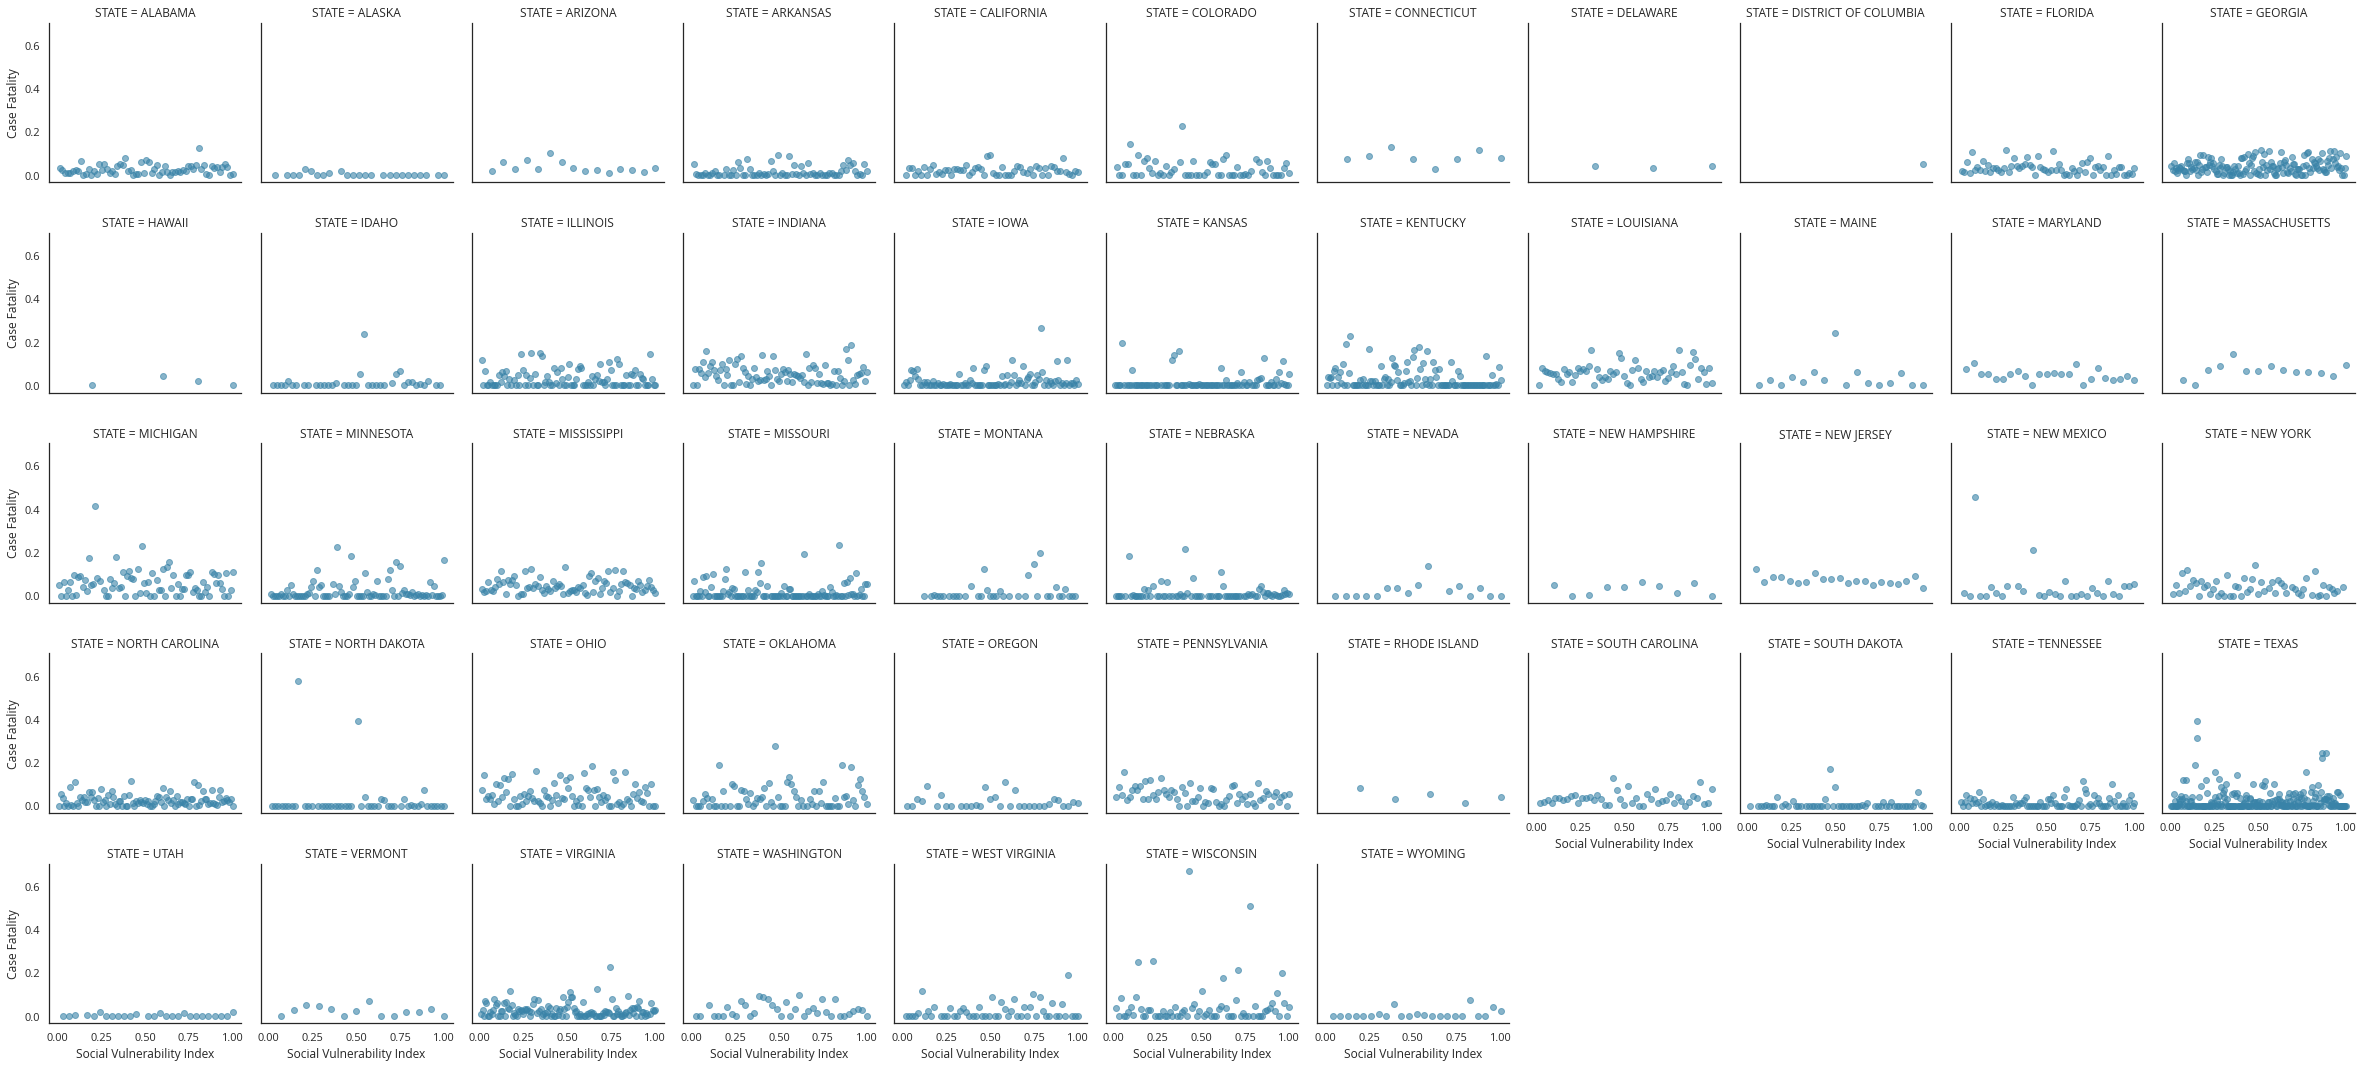

In [105]:
all_counties = sns.FacetGrid(total_covid_svi,col='STATE',col_wrap=11)
all_counties = all_counties.map(plt.scatter, "RPL_ThemesStates", "case_fatality", color='#3983A8',alpha=0.6).set_axis_labels('Social Vulnerability Index','Case Fatality')

## II.a Case fatalities versus SVI composite index for counties with more than 50 cases

Case fatalities (number of deaths / number of cases) calculated for each county plotted against the composite social vulnerability index. The above 50 threshold is drawn from the [methodology](https://precisionforcovid.org/ccvi) used by the Surgo Foundation to validate their COVID vulnerability index.  


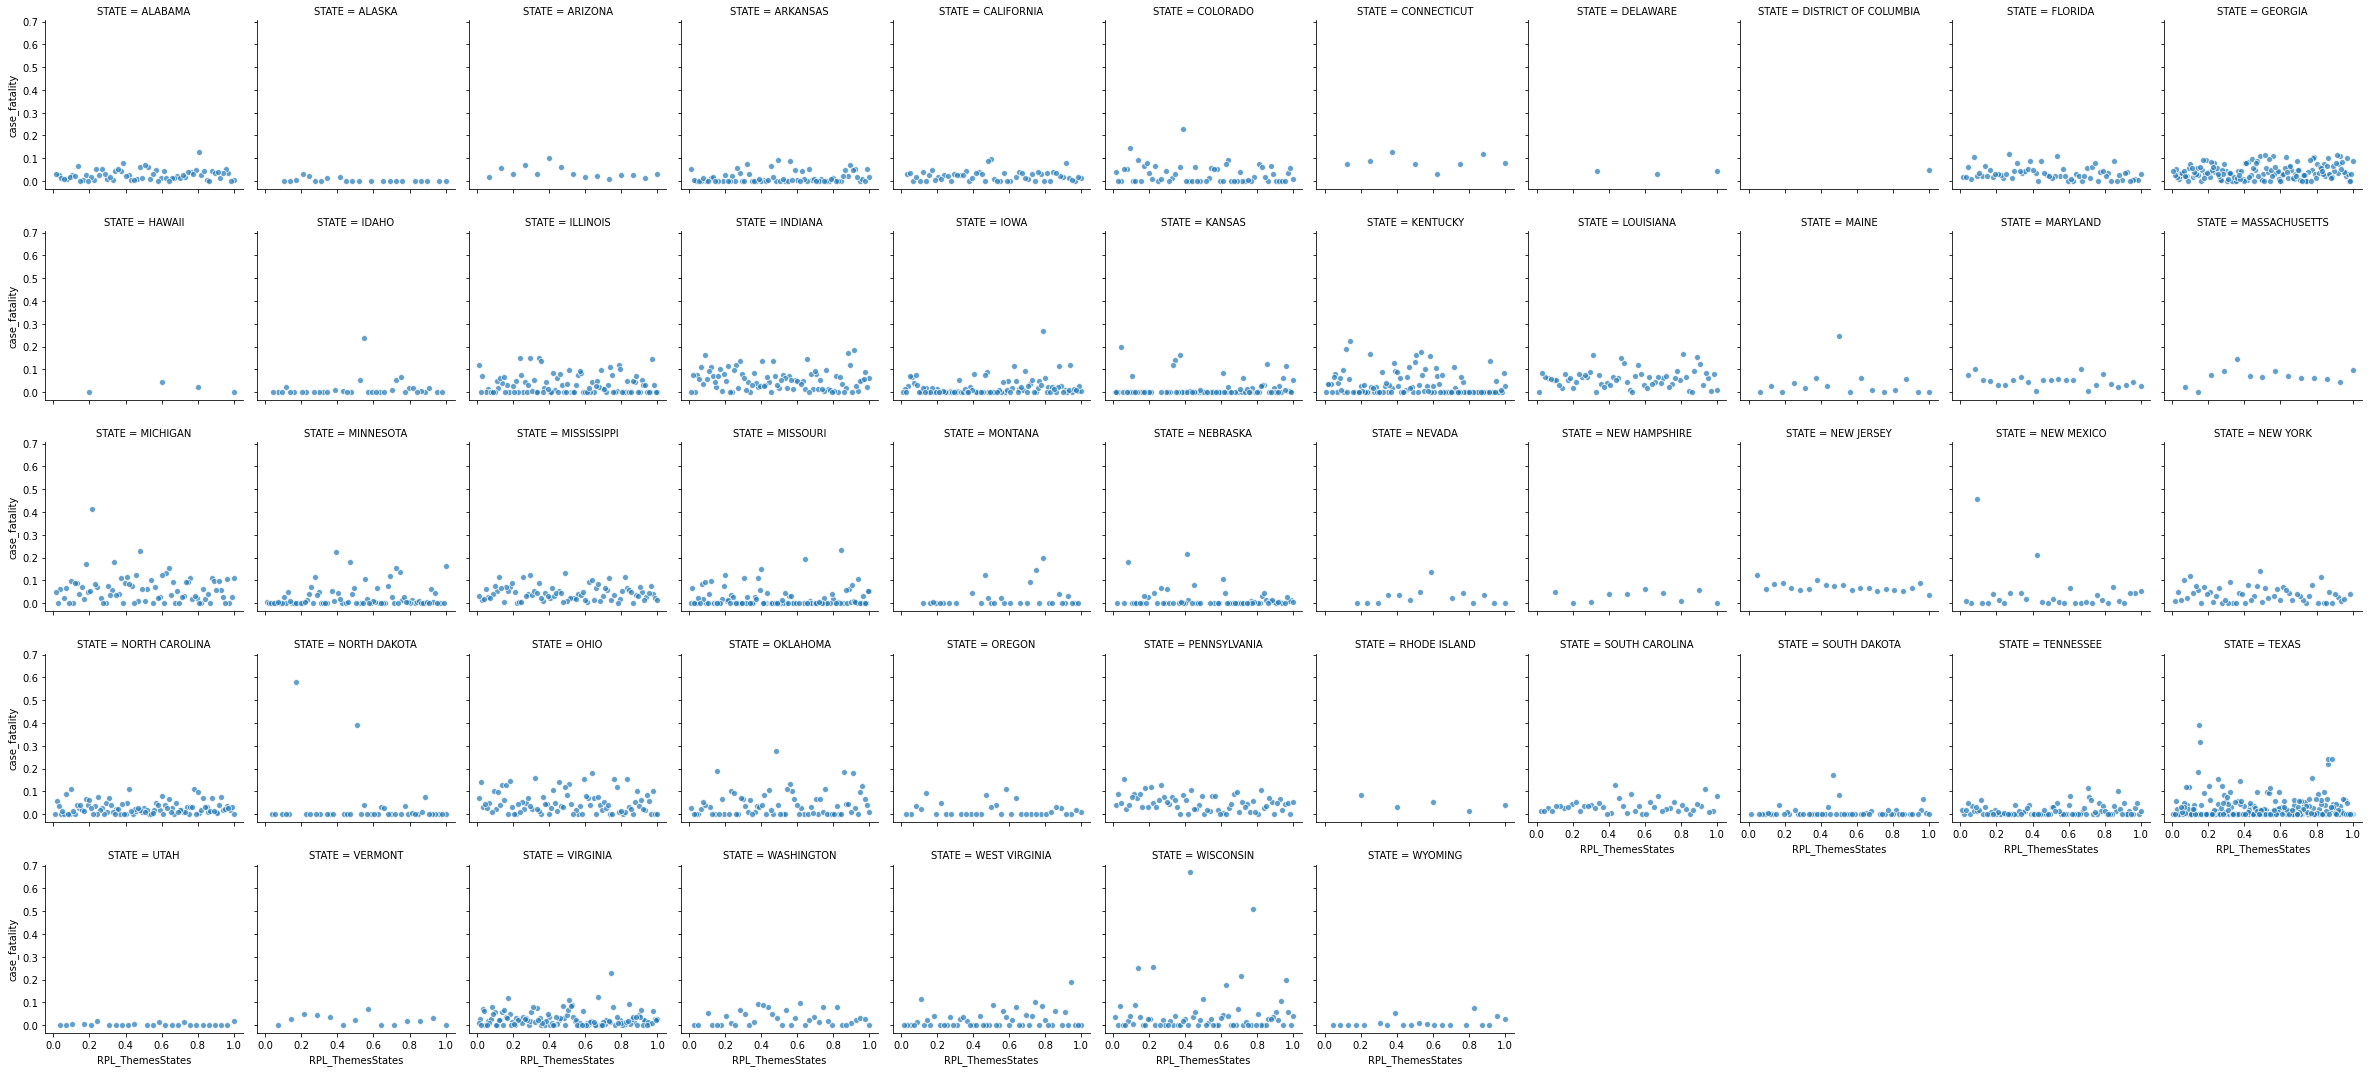

In [82]:
above50 = sns.FacetGrid(total_covid_svi[total_covid_svi['cases']>50],col='STATE',col_wrap=11)
above50 = above50.map(plt.scatter, "RPL_ThemesStates", "case_fatality", alpha=0.7,edgecolor="w")

## III. Case fatalities versus SVI socioeconomic theme 
Case fatalities (number of deaths / number of cases) calculated for each county plotted against the social vulnerability index for socioeconomic variables. 

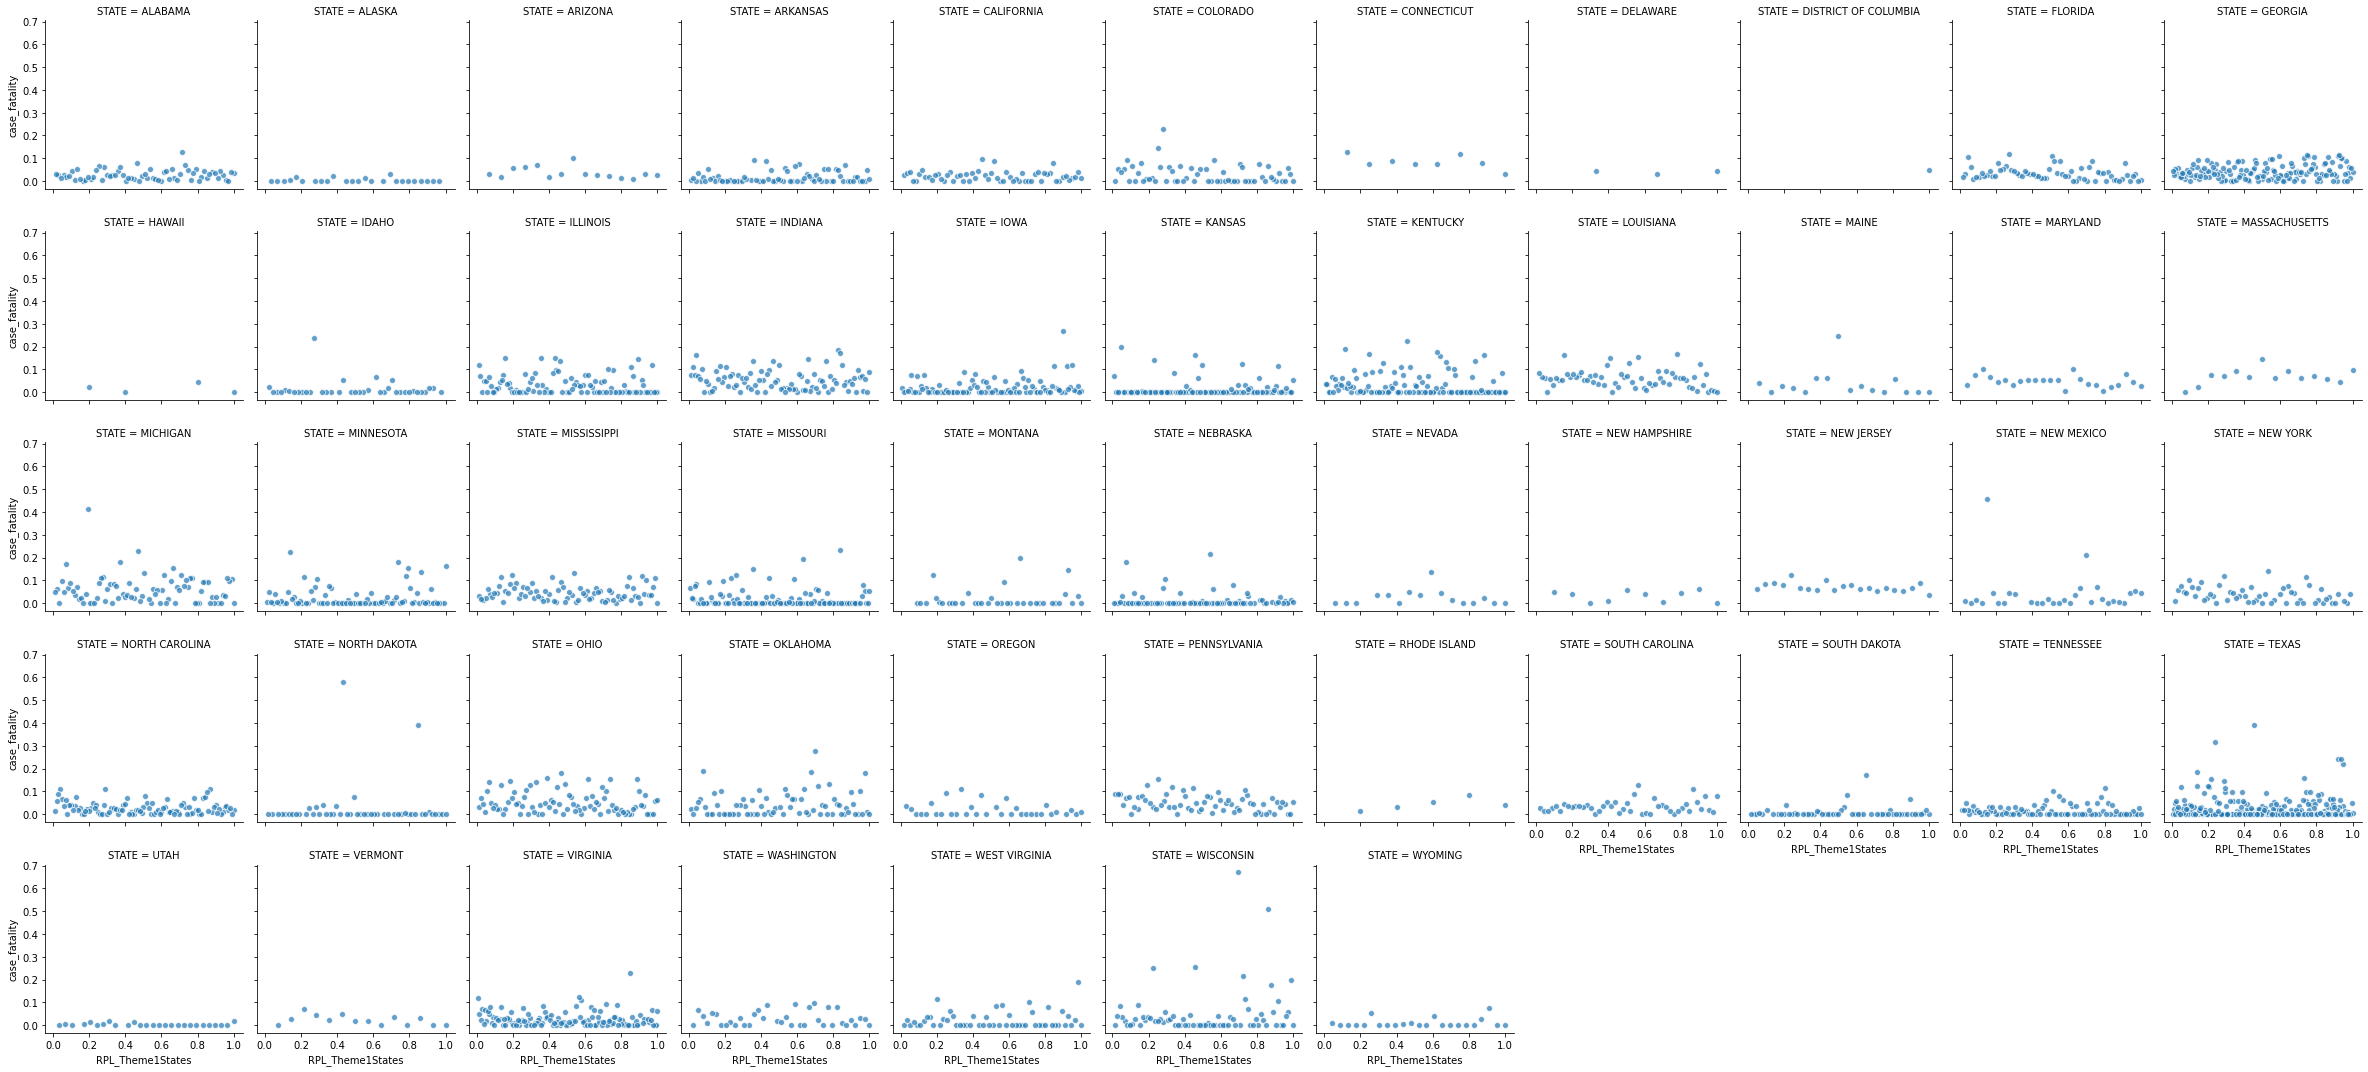

In [84]:
all_counties = sns.FacetGrid(total_covid_svi,col='STATE',col_wrap=11)
all_counties1 = all_counties.map(plt.scatter, "RPL_Theme1States", "case_fatality", alpha=0.7,edgecolor="w")

## IV. Case fatalities versus SVI Household Composition theme 
Case fatalities (number of deaths / number of cases) calculated for each county plotted against the social vulnerability index for household composition variables. 

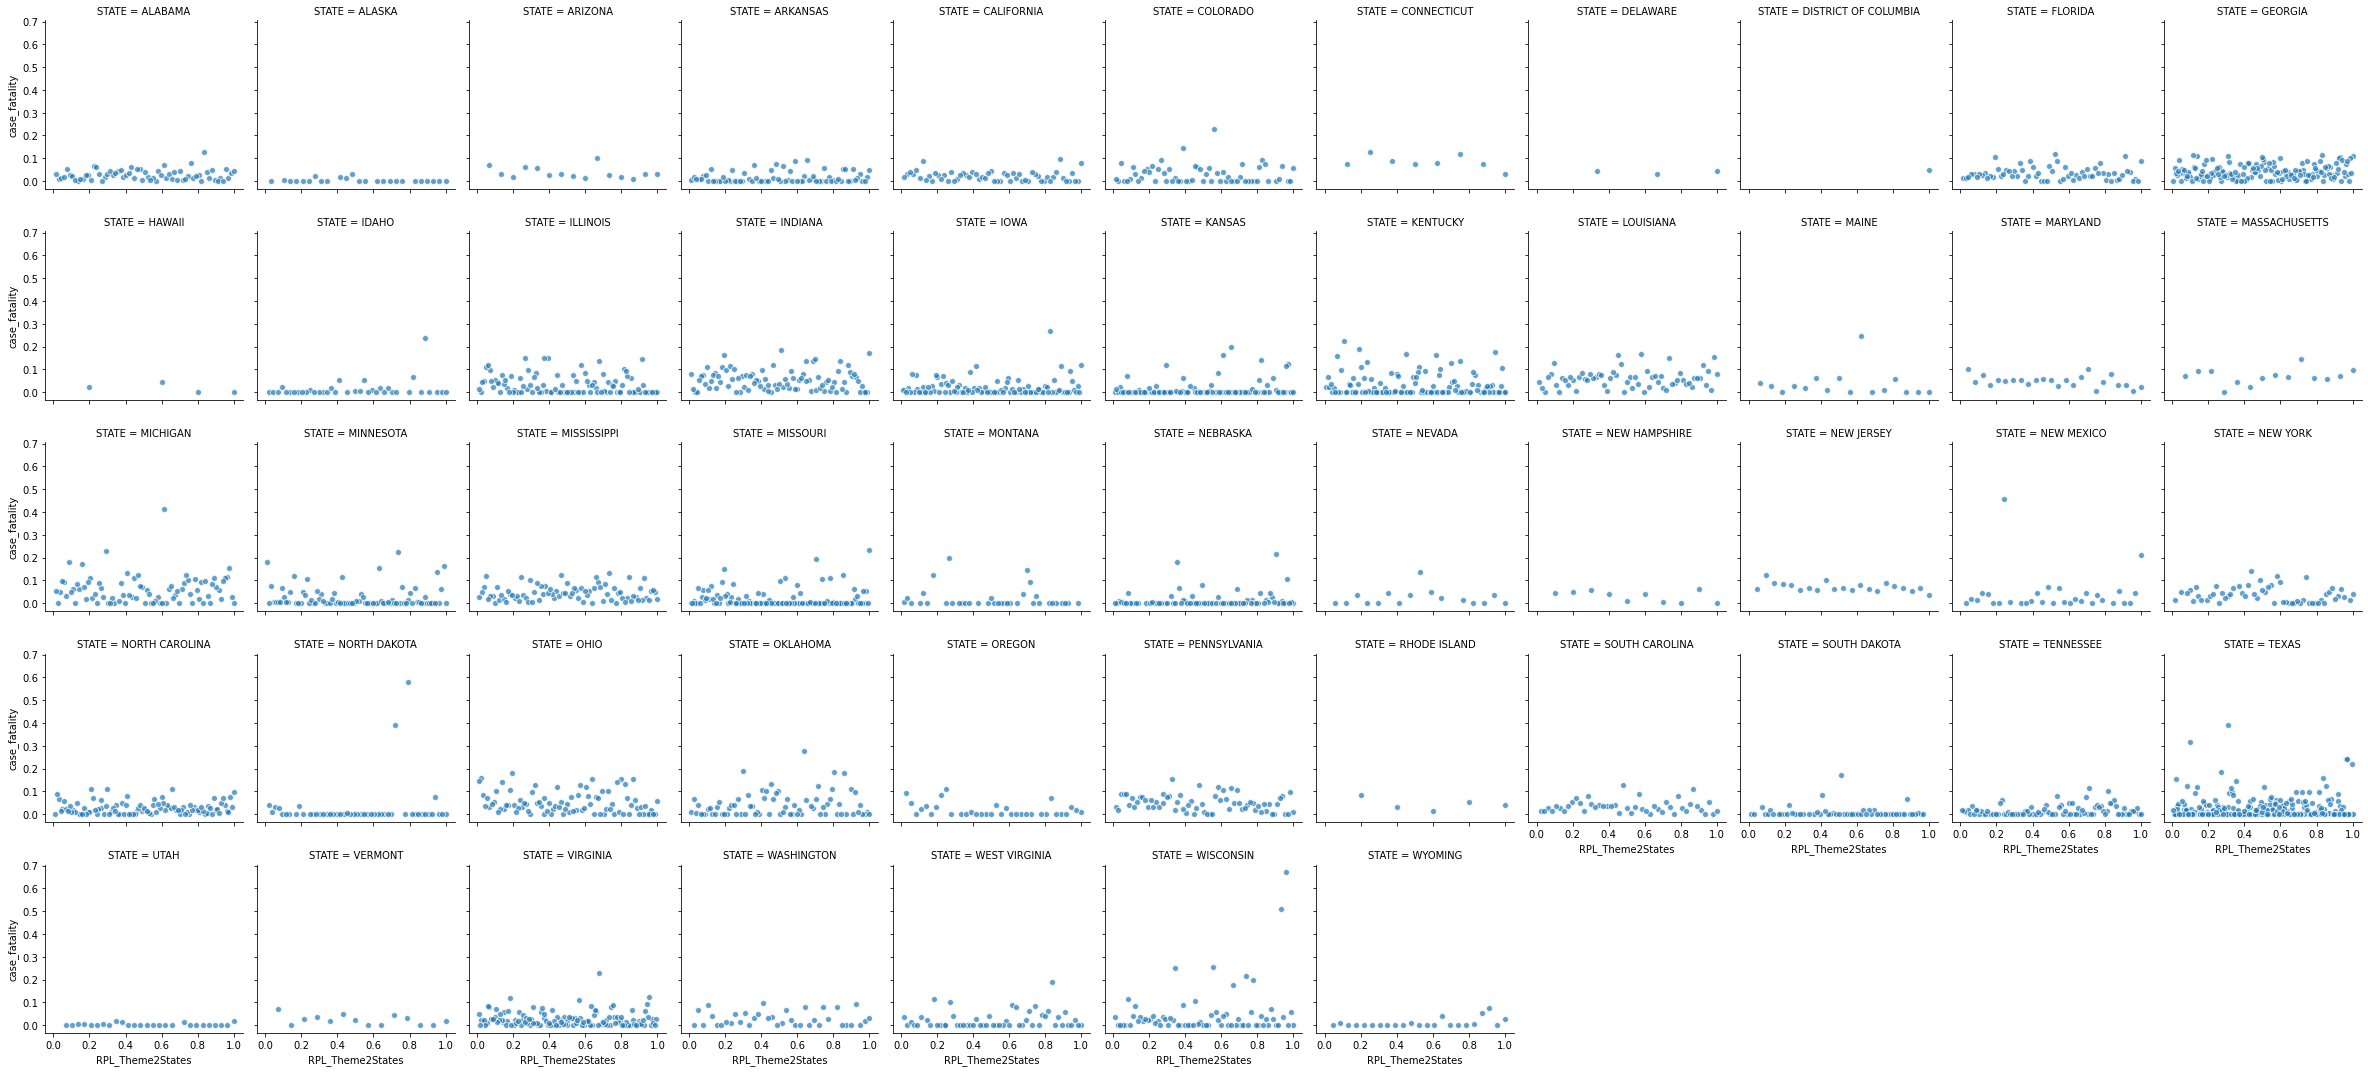

In [85]:
all_counties = sns.FacetGrid(total_covid_svi,col='STATE',col_wrap=11)
all_counties2 = all_counties.map(plt.scatter, "RPL_Theme2States", "case_fatality", alpha=0.7,edgecolor="w")

## V. Case fatalities versus SVI Minority Status theme 
Case fatalities (number of deaths / number of cases) calculated for each county plotted against the social vulnerability index for minority status variables. 

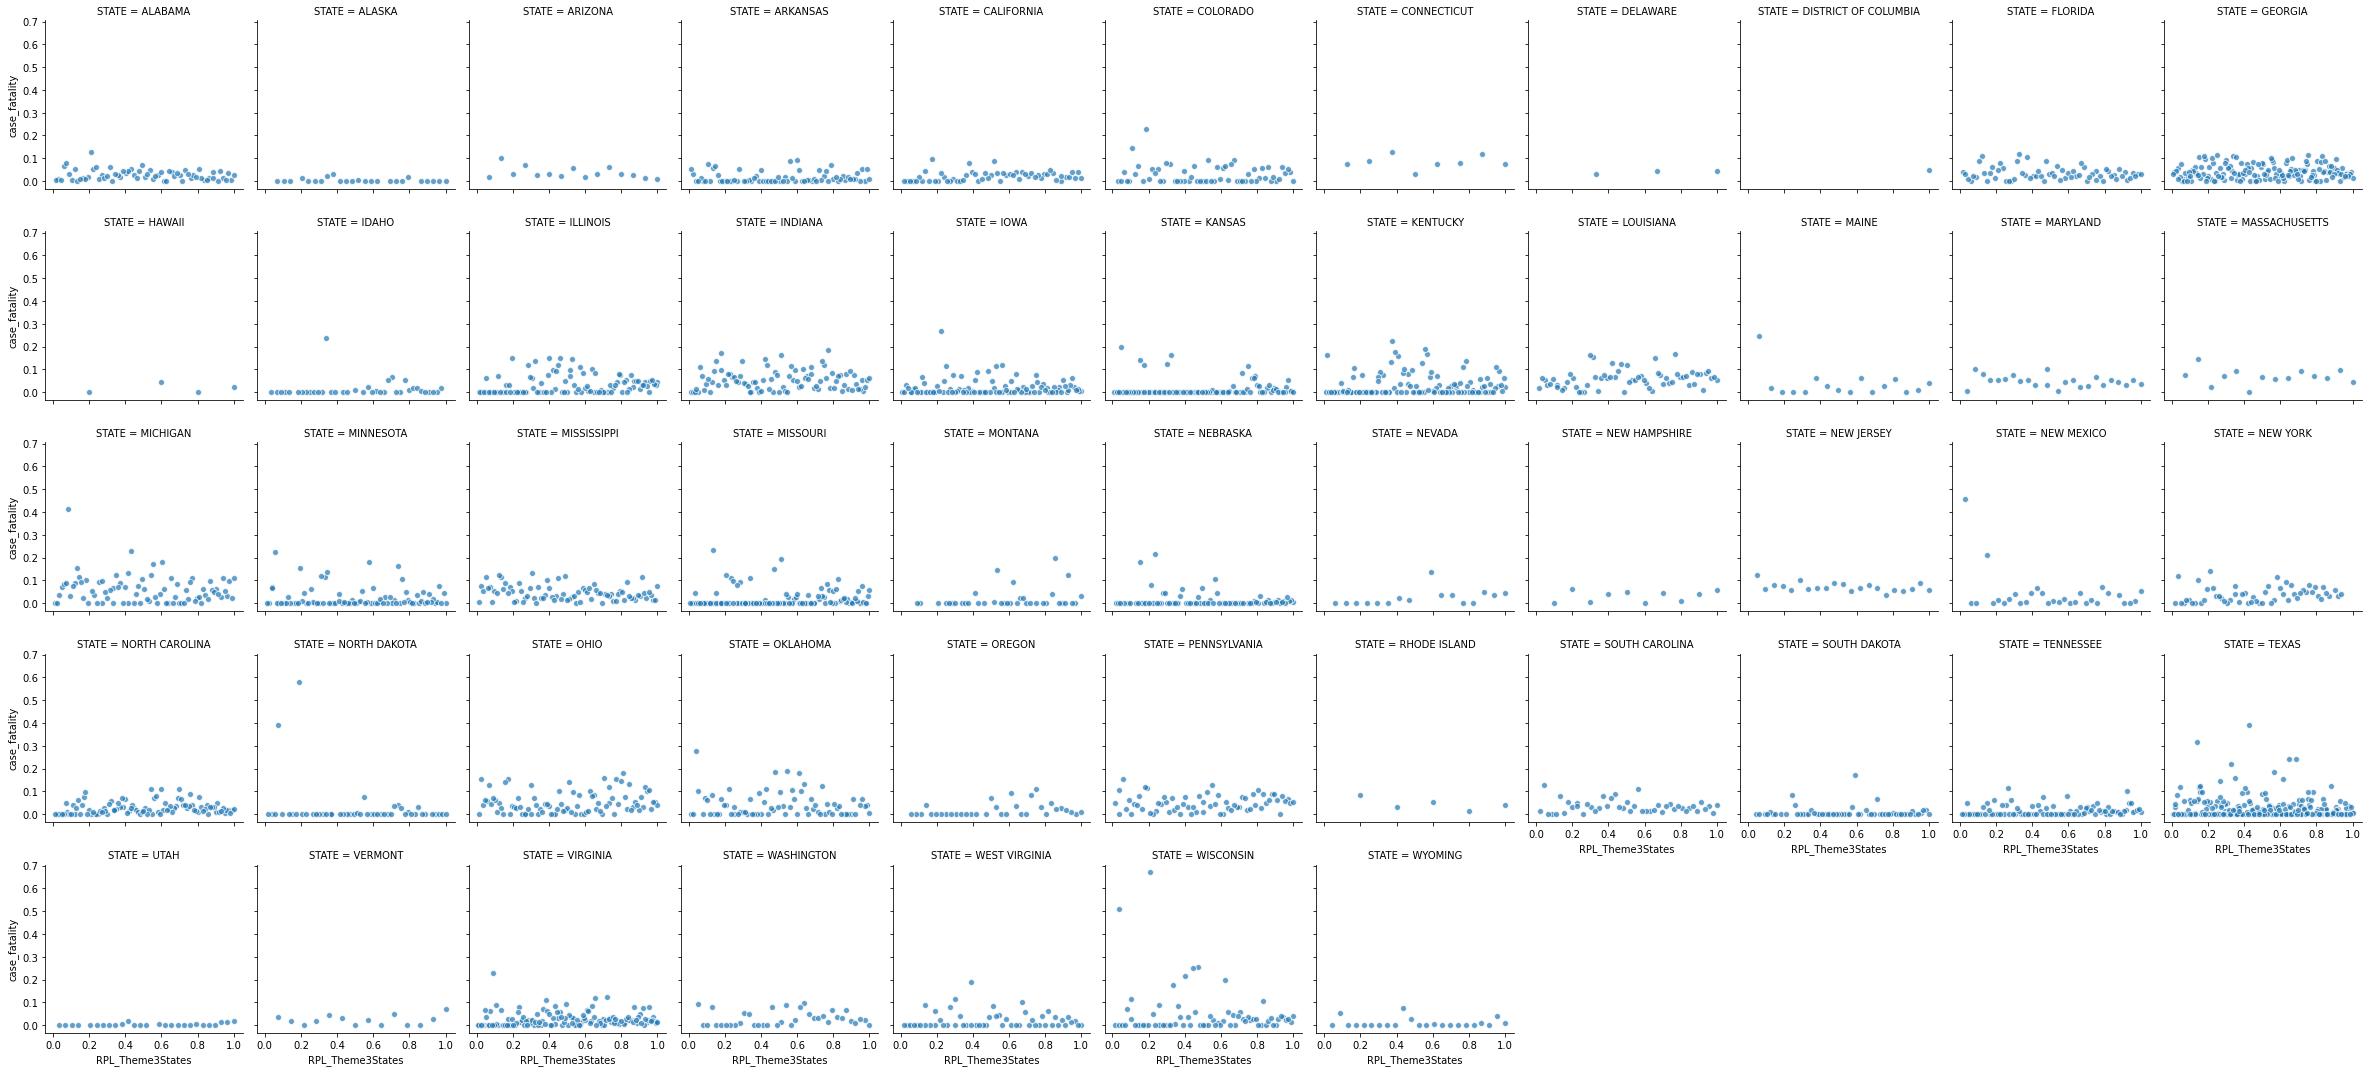

In [87]:
all_counties = sns.FacetGrid(total_covid_svi,col='STATE',col_wrap=11)
all_counties3 = all_counties.map(plt.scatter, "RPL_Theme3States", "case_fatality", alpha=0.7,edgecolor="w")

## VI. Case fatalities versus SVI Housing Type theme 
Case fatalities (number of deaths / number of cases) calculated for each county plotted against the social vulnerability index for housing type variables. 

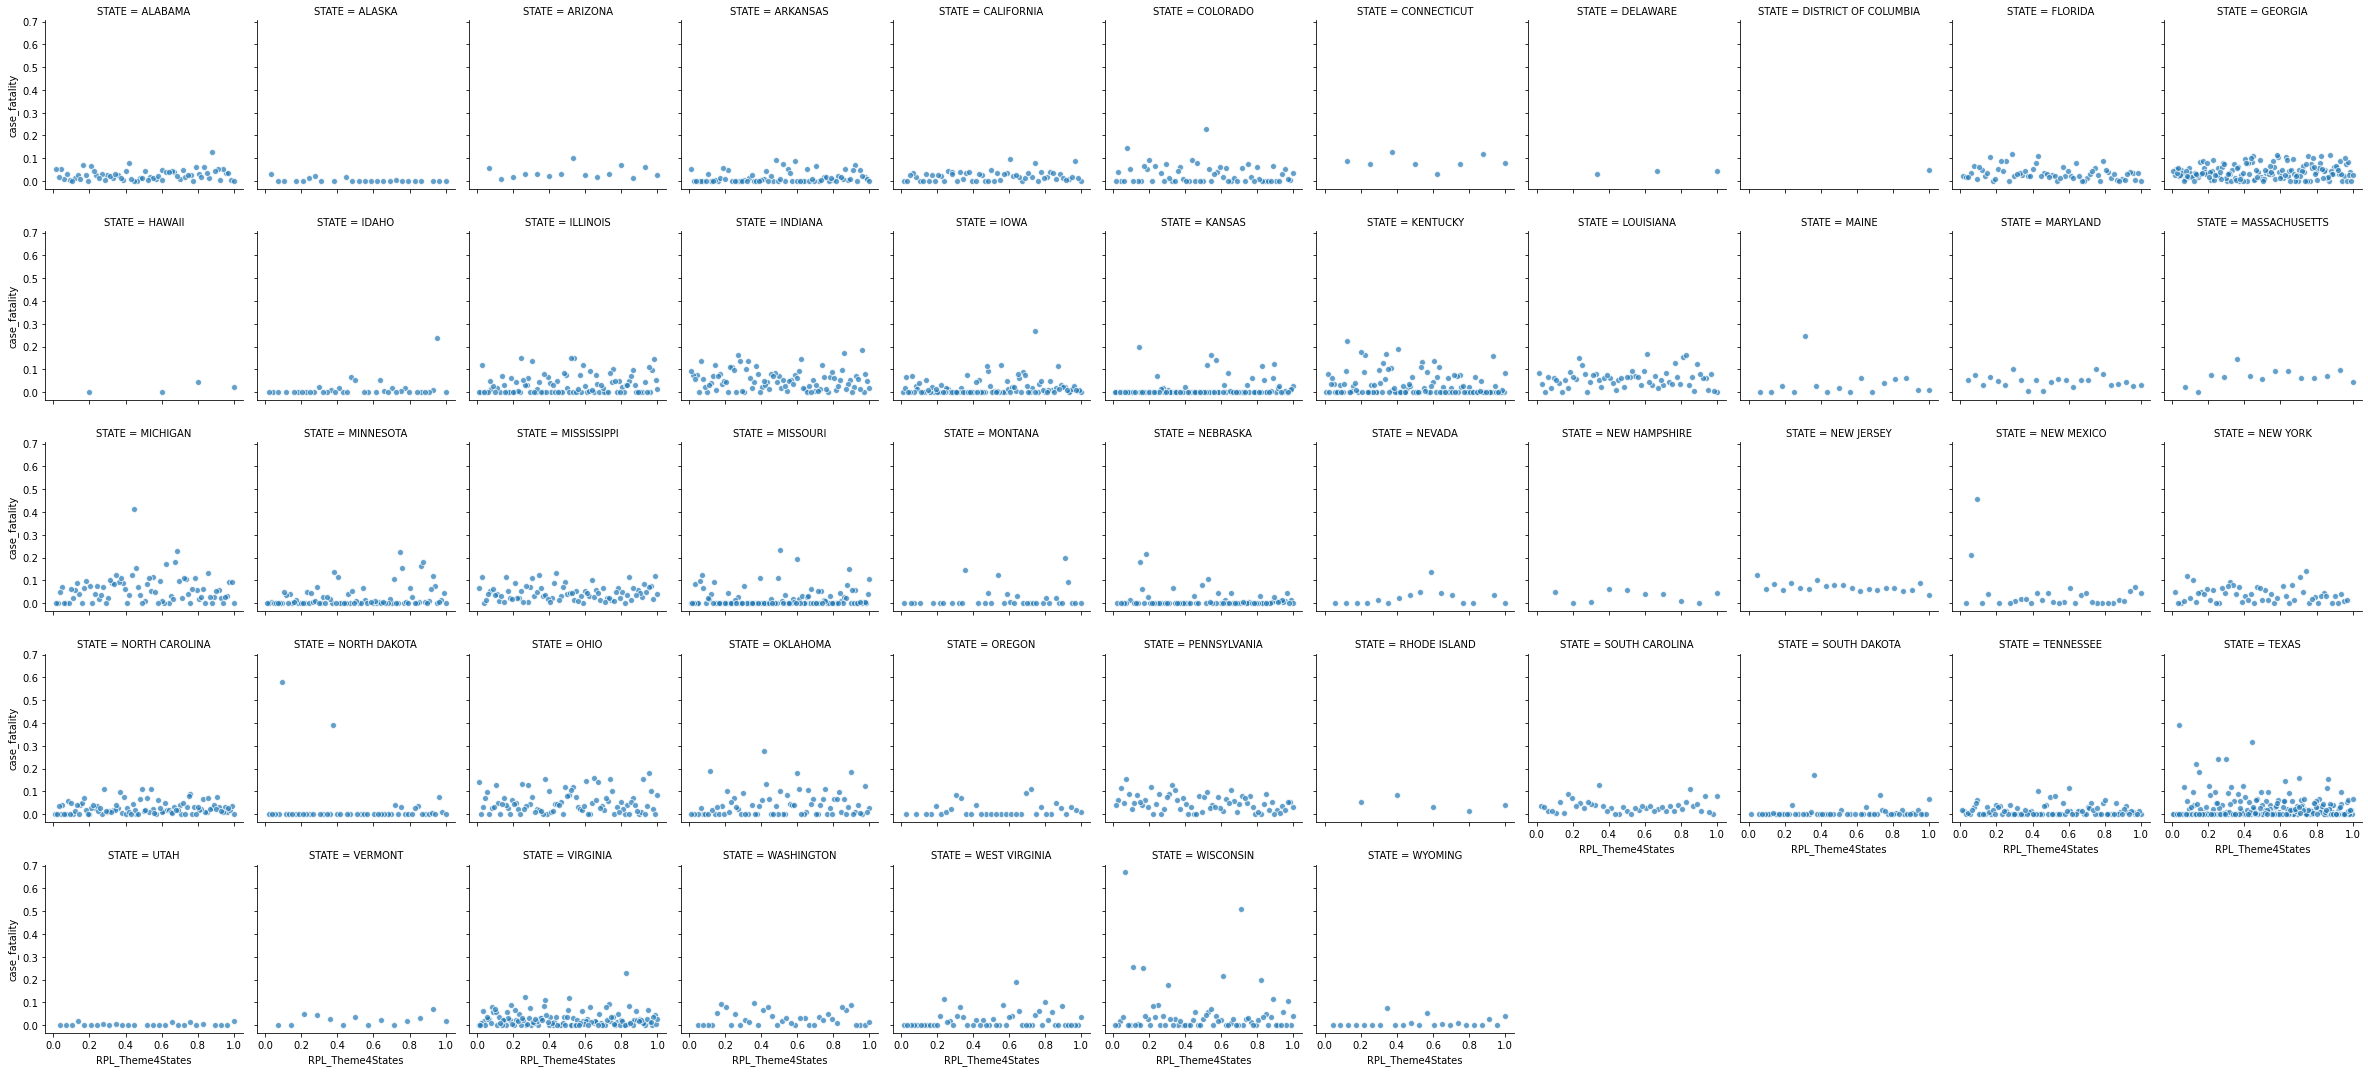

In [88]:
all_counties = sns.FacetGrid(total_covid_svi,col='STATE',col_wrap=11)
all_counties4 = all_counties.map(plt.scatter, "RPL_Theme4States", "case_fatality", alpha=0.7,edgecolor="w")

In [106]:
meat = pd.read_csv("./data_processing/naics_311612_referenceusa_ - naics_311612_referenceusa_.csv")

In [109]:
meat_geo = gpd.GeoDataFrame(
    meat, geometry=gpd.points_from_xy(meat.Longitude, meat.Latitude))


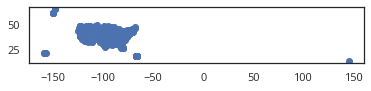

In [110]:
meat_geo[meat_geo['State'].plot()

In [111]:
meat_geo.sort_values(by='Longitude',ascending=False)

,Company Name,Executive First Name,Executive Last Name,Address,City,State,ZIP Code,Full Address,Latitude,Longitude,Credit Score Alpha,Executive Gender,Executive Title,Fax Number Combined,IUSA Number,Location Employee Size Range,Location Sales Volume Range,Phone Number Combined,Primary SIC Code,Primary SIC Description,SIC Code 1,SIC Code 1 Description,Record Type,geometry
172,L S Reyes Products,Marilyn,Sanga,107108 Dos Amantes Plz,Barrigada,GU,96929,107108 Dos Amantes Plz Barrigada GU 96929,13.527039,144.884404,U,Female,Manager,NaN,43-965-4793,5 to 9,$1-2.5 Million,(671) 647-2627,201398,Sausages/Other Prepared Meat Prod (Mfrs),201398,Sausages/Other Prepared Meat Prod (Mfrs),Verified,POINT (144.884 13.527)
521,Tiendita LA Seyba,NaN,NaN,110 Ave Lauro Pinero,Ceiba,PR,735,110 Ave Lauro Pinero Ceiba PR 735,18.269759,-65.644137,U,NaN,NaN,NaN,90-219-6062,1 to 4,$5-10 Million,(787) 885-0228,514701,Butchering (Whls),514701,Butchering (Whls),Verified,POINT (-65.644 18.270)
510,Granja & Carniceria LA Fvrt,NaN,NaN,110 Calle Dr Lopez W,Fajardo,PR,738,110 Calle Dr Lopez W Fajardo PR 738,18.324314,-65.654700,U,NaN,NaN,NaN,90-219-6039,1 to 4,$5-10 Million,(787) 863-3616,514701,Butchering (Whls),514701,Butchering (Whls),Verified,POINT (-65.655 18.324)
969,Carniceria LA Gitana,NaN,NaN,7 Plaza Del Mercado,Naguabo,PR,718,7 Plaza Del Mercado Naguabo PR 718,18.212715,-65.736461,U,NaN,NaN,NaN,20-782-2388,1 to 4,$5-10 Million,(787) 874-0580,514701,Butchering (Whls),514701,Butchering (Whls),Verified,POINT (-65.736 18.213)
968,Carniceria Gui,NaN,NaN,6 Calle Francisco Vega S,Humacao,PR,791,6 Calle Francisco Vega S Humacao PR 791,18.149318,-65.828601,U,NaN,NaN,NaN,90-221-8338,1 to 4,$5-10 Million,(787) 852-6844,514701,Butchering (Whls),514701,Butchering (Whls),Verified,POINT (-65.829 18.149)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,Purity Foods,Bill,Atherton,2915 Kaihikapu St # 101,Honolulu,HI,96819,2915 Kaihikapu St # 101 Honolulu HI 96819,21.339644,-157.899182,A+,Male,Vice President,8.088477e+09,71-232-7691,10 to 19,$2.5-5 Million,(808) 847-3717,201398,Sausages/Other Prepared Meat Prod (Mfrs),201398,Sausages/Other Prepared Meat Prod (Mfrs),Verified,POINT (-157.899 21.340)
177,Redondo's LLC,Hitoshi,Okada,94-140 Leokane St,Waipahu,HI,96797,94-140 Leokane St Waipahu HI 96797,21.376822,-158.018083,A+,Male,President,8.086767e+09,00-107-8583,20 to 49,$10-20 Million,(808) 671-5444,201398,Sausages/Other Prepared Meat Prod (Mfrs),201398,Sausages/Other Prepared Meat Prod (Mfrs),Verified,POINT (-158.018 21.377)
174,Kunoa Cattle Co,Leonard,Oshiro,91-319 Olai St # 1,Kapolei,HI,96707,91-319 Olai St # 1 Kapolei HI 96707,21.299587,-158.097082,A+,Male,President,NaN,26-353-2996,10 to 19,$10-20 Million,(808) 682-2595,514701,Butchering (Whls),514701,Butchering (Whls),Verified,POINT (-158.097 21.300)
592,Deep Cuts Dallas,Nate,Abeyta,7989 Belt Line Rd # 146,Dallas,TX,75248,7989 Belt Line Rd # 146 Dallas TX 75248,NaN,NaN,B+,Male,Owner,NaN,73-405-2650,1 to 4,$5-10 Million,(469) 906-6420,514701,Butchering (Whls),514701,Butchering (Whls),Verified,POINT (nan nan)
